<a href="https://colab.research.google.com/github/K-107/exercise/blob/main/bone_segmentation/label_generater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 색 변경 참고 자료

이미지 색상 변경

- https://www.python2.net/questions-223985.htm
- https://bigdata-analyst.tistory.com/134

RGB 색상 코드값

- https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=lee_jinhwan&logNo=220062406307

이미지 겹치기 (강추!!)

- https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0

In [54]:
# OpenCV의 COLOR에 관한 많은 flag들...

print([x for x in dir(cv2) if x.startswith('COLOR_')]) # all flag list

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

In [55]:
tmp = [x for x in dir(cv2) if x.startswith('COLOR_')]
len(tmp)
# 274개다.

274

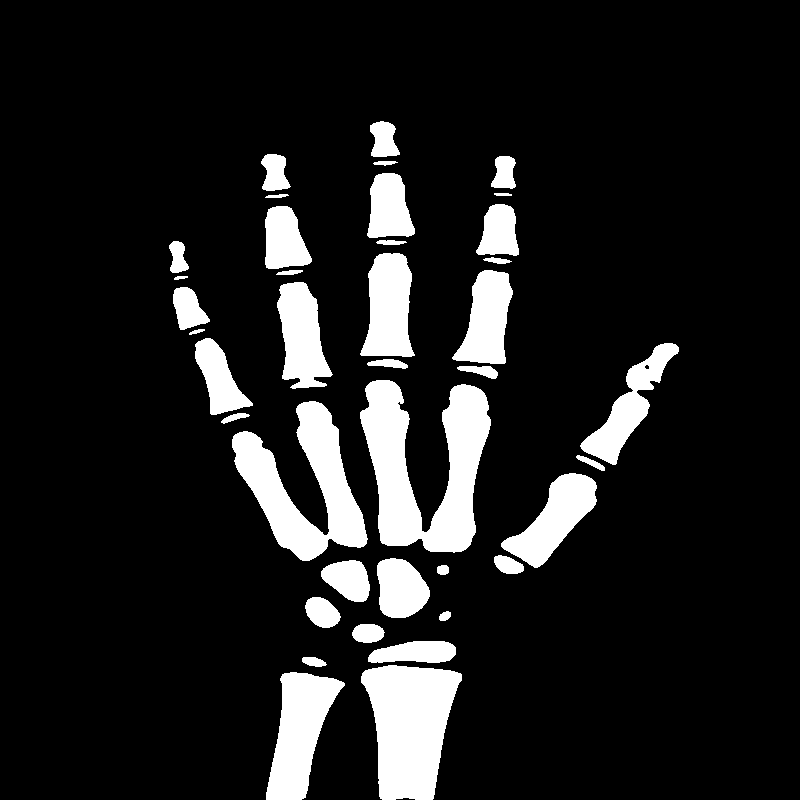

In [29]:
from google.colab.patches import cv2_imshow

OUTPUT_PATH = '/content/drive/MyDrive/bone/result'

img = cv2.imread(OUTPUT_PATH+'/output.png', cv2.IMREAD_ANYCOLOR)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # color to gray
cv2_imshow(gray_img)

cv2.waitKey()
cv2.destroyAllWindows()

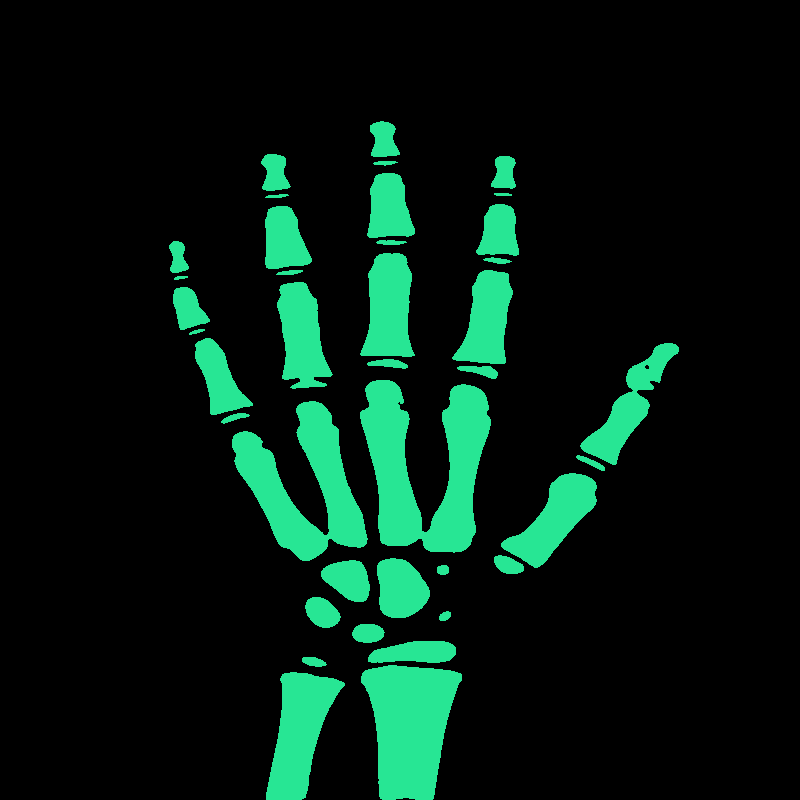

In [31]:
# Load image and ensure greyscale
im = Image.open(OUTPUT_PATH+'/output.png').convert('L')

# Make Numpy version for fast, efficient access
npim = np.array(im) # (800, 800)이다.

# Make solid black RGB output image, same width and height but 3 channels (RGB)
res = np.zeros((npim.shape[0],npim.shape[1],3), dtype=np.uint8)

# Anywhere the grey image is >127, make result image new colour
res[npim>250] = [148,230,39] # 안전빵으로 250으로 하자!

# 이미지 확인
cv2_imshow(res)

# Convert back to PIL Image and save to disk
Image.fromarray(res).save(OUTPUT_PATH+'/result.png')

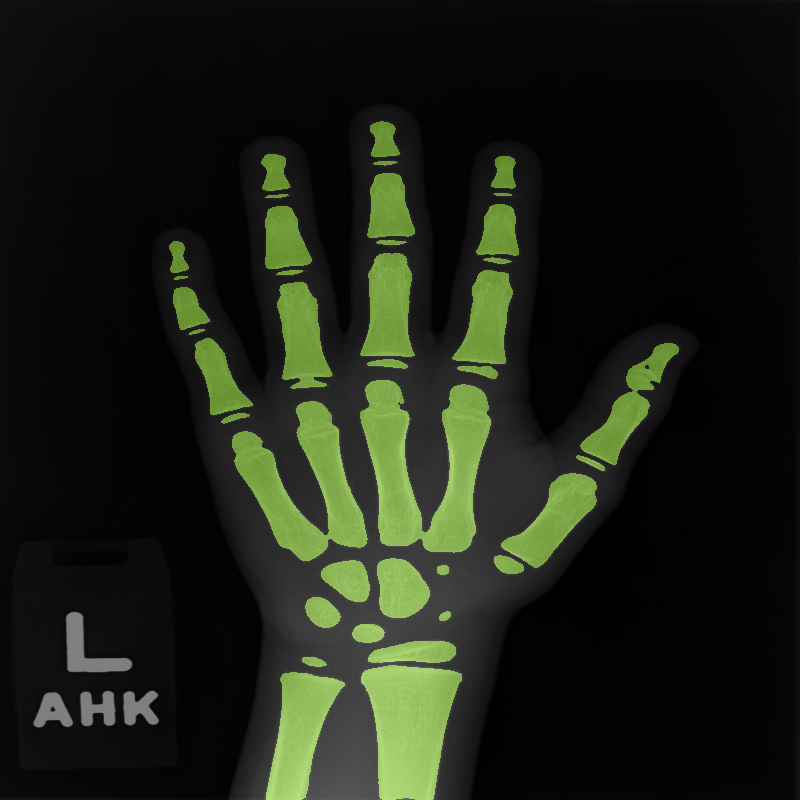

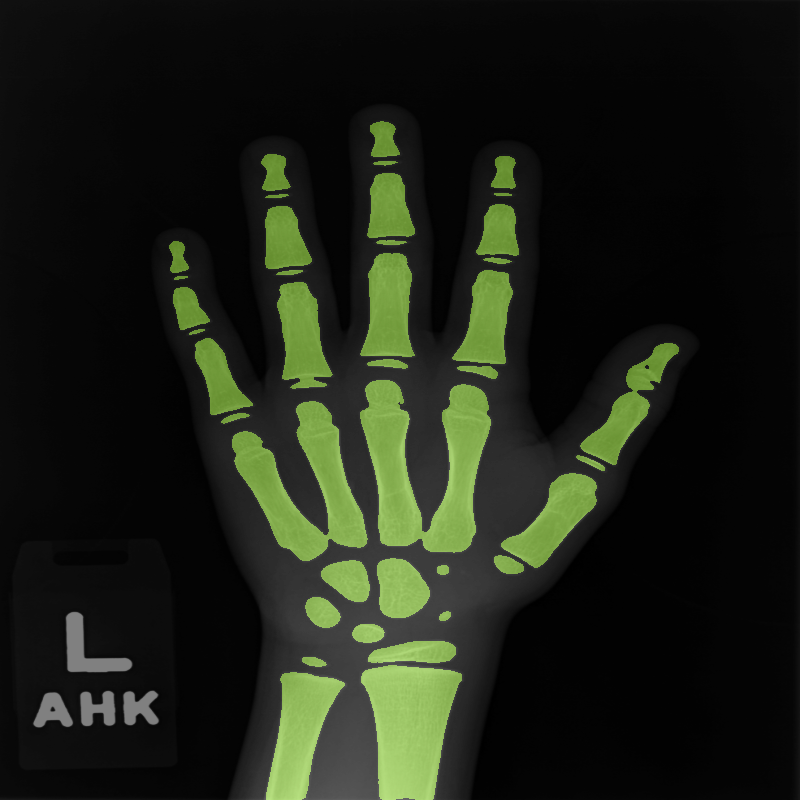

In [40]:
# 이미지 겹치기
# 알파 블렌딩 (blending_alpha.py)

import cv2
import numpy as np

alpha = 0.5 # 합성에 사용할 알파 값

#---① 합성에 사용할 영상 읽기
img1 = cv2.imread(OUTPUT_PATH+'/input.png')
img2 = cv2.imread(OUTPUT_PATH+'/result.png')

# ---② NumPy 배열에 수식을 직접 연산해서 알파 블렌딩 적용
blended = img1 * alpha + img2 * (1-alpha)
blended = blended.astype(np.uint8) # 소수점 발생을 제거하기 위함
cv2_imshow(blended)

# ---③ addWeighted() 함수로 알파 블렌딩 적용
dst = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0) 
cv2_imshow(dst)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [57]:
# bitwise_and 연산으로 마스킹하기 (bitwise_masking.py)

img1 = cv2.imread(OUTPUT_PATH+'/input.png')
gray_img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
input_img = np.array(gray_img1)

img2 = cv2.imread(OUTPUT_PATH+'/output.png')
gray_img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
output_img = np.array(gray_img2)

input_img.shape, output_img.shape

((800, 800), (800, 800))

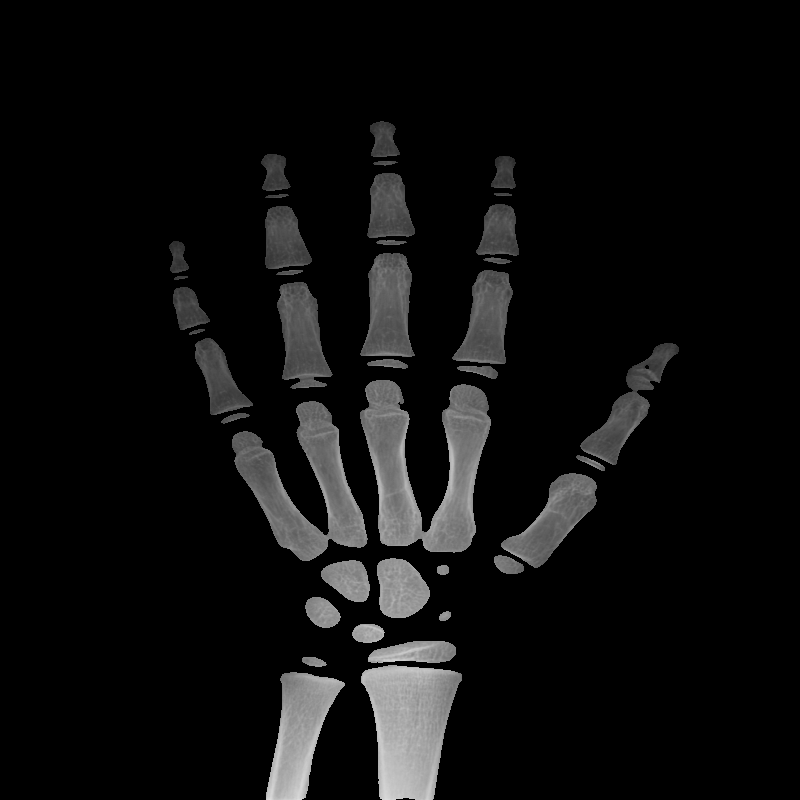

In [61]:
masked = cv2.bitwise_and(input_img, output_img)
cv2_imshow(masked)

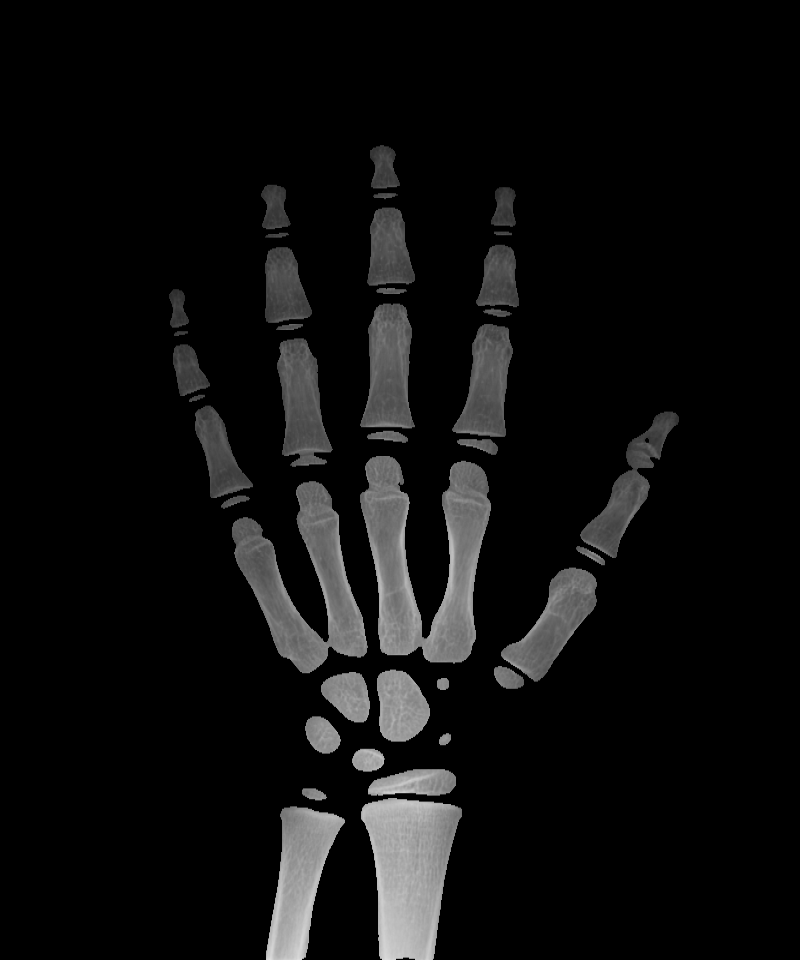

In [65]:
# 보간법 적용

interpolation = cv2.resize(masked, None, None, 1, 1.2, interpolation=cv2.INTER_AREA)
cv2_imshow(interpolation)